In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from numpy.random import uniform, lognormal, normal
import matplotlib.pyplot as plt 
from astropy.modeling.models import Sersic2D

from tensorflow.config import list_logical_devices, list_physical_devices, set_visible_devices
from tensorflow.config.experimental import set_memory_growth


In [2]:
def setup_tensorflow(seed=None):
    try:
        import nvsmi

        gpu_mem_free = np.array([gpu.mem_free for gpu in nvsmi.get_gpus()])
        if len(gpu_mem_free) > 0 and (gpu_mem_free > 0).any():
            idx = np.argmax(gpu_mem_free)
            gpu = list_physical_devices("GPU")[idx]
            set_memory_growth(gpu, True)
            set_visible_devices(gpu, "GPU")
            gpus = list_logical_devices("GPU")
            print(f"Using GPU: {gpus}")
        else:
            raise Exception
    except:
        print(f"Tensorflow using CPU")
    tf.random.set_seed(seed)

In [3]:
setup_tensorflow()

Using GPU: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-05-04 16:55:18.834434: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-04 16:55:22.605071: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9650 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


In [4]:
def make_galaxy_parameters(n_images=3000, n_gal_per_image=1,
                         img_size=(64,64), seed = 12345, plot = True):
    n_gals = (n_gal_per_image, n_images)
    np.random.seed(seed)
    params = dict(
        amplitude = lognormal(0, 0.1, size=n_gals),
        r_eff = lognormal(2, 0.1, size=n_gals),
        n = lognormal(0.5, 0.2, size=n_gals),
        ellip = uniform(0.0, 0.8, size=n_gals),
        x_0 = normal(0.5, 0.1, size=n_gals) * img_size[0],
        y_0 = normal(0.5, 0.1, size=n_gals) * img_size[1],
        theta = uniform(0.0, np.pi, size=n_gals)
    )
    return params

In [5]:
def make_centered_galaxy_parameters(n_images=3000, n_gal_per_image=1,
                         img_size=(64,64), seed = 25356, plot = True):
    n_gals = (n_gal_per_image, n_images)
    np.random.seed(seed)
    centered_params = dict(
        amplitude = lognormal(0, 0.1, size=n_gals),
        r_eff = lognormal(2, 0.1, size=n_gals),
        n = lognormal(0.5, 0.2, size=n_gals),
        ellip = uniform(0.0, 0.8, size=n_gals),
        x_0 =  np.full(n_gals, img_size[0]/2, dtype = int),
        y_0 = np.full(n_gals, img_size[1]/2, dtype = int),
        theta = uniform(0.0, np.pi, size=n_gals)
    )
    return centered_params

In [6]:
def make_blended_gals(params, centered_params, ngal = 30000, img_size=(64, 64)):
    x, y = np.mgrid[:img_size[1], :img_size[0]]
    shape = (2, ngal)
    # Shape = (ngal, n_components)
    components = np.zeros(shape + img_size[::-1])
    blended = np.zeros(shape[1:] + img_size[::-1])
    for img_idx in range(shape[1]):
        centered_par = {p: x[0, img_idx] for p, x in centered_params.items()}
        centered_mod = Sersic2D(**centered_par)(y, x)
        centered_mod = add_noise(centered_mod)
        centered_mod = asinh_scale(centered_mod)
        components[0, img_idx] = centered_mod
        blended[img_idx] += centered_mod
        par = {p: x[0, img_idx] for p, x in params.items()}
        mod = Sersic2D(**par)(y, x)
        mod = add_noise(mod)
        mod = asinh_scale(mod)
        components[1, img_idx] = mod 
        blended[img_idx] += mod
    return components, blended

In [7]:
def add_noise(img, scale=0.01):
    return img + normal(scale=scale, size=img.shape)


In [8]:
def asinh_scale(x, a=0.1, inverse=False):
    # This is a common way of scaling astronomical images
    # so that inner and outer regions of galaxies can be seen
    return np.arcsinh(x / a) / np.arcsinh(1 / a)

In [9]:

ngal = 3000
ncomp = 1

params = make_galaxy_parameters(ngal, plot=False)
centered_params = make_centered_galaxy_parameters(ngal, plot=False)

components, blended = make_blended_gals(params, centered_params, ngal)



In [10]:
blended.shape, components.shape

((3000, 64, 64), (2, 3000, 64, 64))

In [11]:
#This should equal 0
print(np.sum(blended - (components[0] + components[1])))

0.0


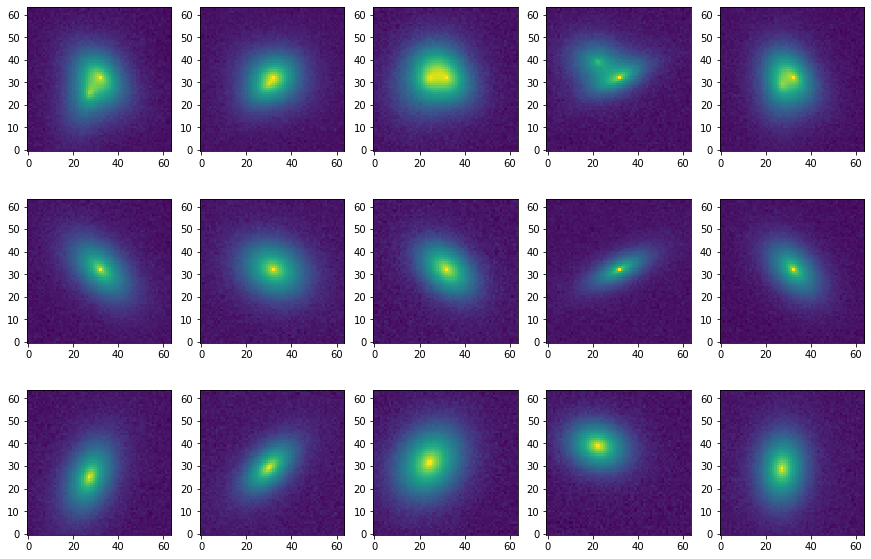

In [12]:
fig, ax = plt.subplots(3, 5, figsize=(15, 10))
for i in range(5):
    ax[0, i].imshow(blended[i], origin='lower', interpolation='nearest')
    for j in range(2):
        ax[j + 1, i].imshow(components[j, i], origin='lower', interpolation='nearest') 

In [13]:
np.save("central_blends.npy", blended)
np.save("central_components.npy", components)